In [1]:
#Libraries
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import tensorflow as tf
import matplotlib.pyplot as plt
import random

In [2]:
# Function to load images and labels from a directory
def load_images_from_directory(directory):
    images = []
    labels = []
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                try:
                    image = Image.open(image_path).convert('RGB')
                    image = image.resize((224, 224))  # Resize to 224x224
                    image = np.array(image) / 255.0
                    images.append(image)
                    labels.append(class_name)
                except Exception as e:
                    print(f"Error loading image {image_path}: {str(e)}")
    return np.array(images), np.array(labels)

In [3]:
# Load images and labels
data_directory = "dataset/"
train_images, train_labels = load_images_from_directory(data_directory)

In [4]:
# Encode labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)

In [5]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, 
                train_labels, test_size=0.2, random_state=42)

In [6]:
# Get class labels
class_labels = label_encoder.classes_
print("Number of classes:", len(class_labels))
print("Class labels:", class_labels)

Number of classes: 9
Class labels: ['Cardboard' 'Food Organics' 'Glass' 'Metal' 'Miscellaneous Trash' 'Paper'
 'Plastic' 'Textile Trash' 'Vegetation']


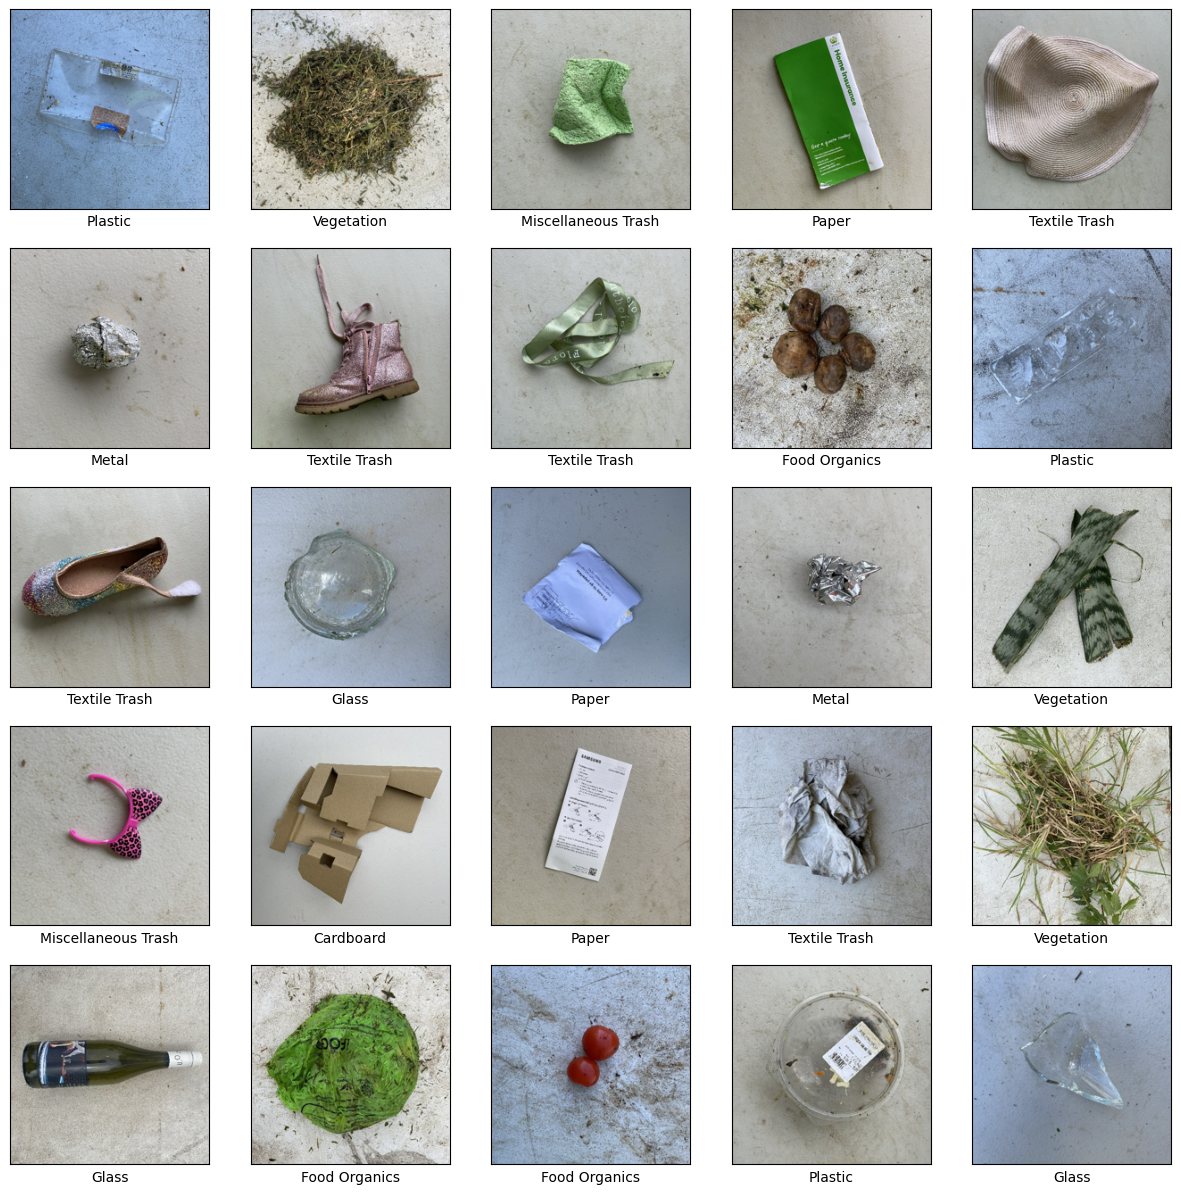

In [7]:
# Display some sample images
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    plt.xlabel(class_labels[y_train[i]])
plt.show()

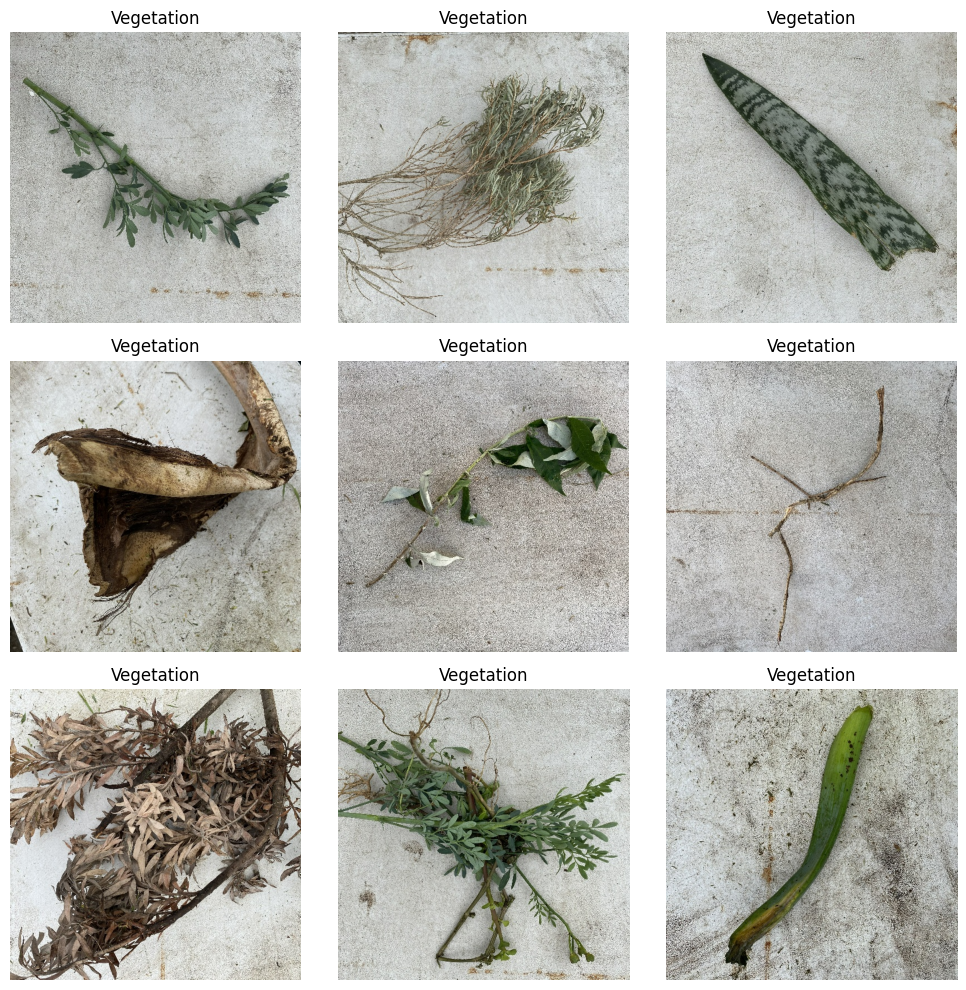

In [8]:
# Directory containing the dataset
data_directory = "dataset/"  # Update this to your dataset path
class_name = "Vegetation"  # Class to visualize
class_path = os.path.join(data_directory, class_name)

# Function to load and visualize random images from the "Vegatation" class
def visualize_random_class_images(class_path, class_name, num_images=9):
    # Get all image file paths in the class folder
    image_files = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
    
    # Randomly select `num_images` images
    random_images = random.sample(image_files, min(len(image_files), num_images))
    
    # Create a grid to display images
    plt.figure(figsize=(10, 10))
    for i, image_path in enumerate(random_images):
        try:
            image = Image.open(image_path)
            plt.subplot(3, 3, i + 1)  # Create a 3x3 grid
            plt.imshow(image)
            plt.axis('off')
            plt.title(class_name)
        except Exception as e:
            print(f"Error loading image {image_path}: {str(e)}")
    
    plt.tight_layout()
    plt.show()

# Visualize random Metal class images
visualize_random_class_images(class_path, class_name)


In [9]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

In [10]:
#Data augmentation for future improvements
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Resizing(224, 224),  # Resize to 224x224
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])


In [11]:
# Using a pretrained model: MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),  # Specify input shape
    include_top=False,         # Exclude fully connected layers
    weights='imagenet'         # Use pretrained weights
)

# Fine-tuning: Unfreeze the last 10 layers of the base model
base_model.trainable = True
for layer in base_model.layers[:-10]:  # Freeze all but the last 20 layers
    layer.trainable = False

# Build the model
cnn = tf.keras.Sequential([
    data_augmentation,                          # Apply data augmentation
    base_model,                                  # Pretrained base model
    tf.keras.layers.GlobalAveragePooling2D(),   # Pooling layer to reduce spatial dimensions
    tf.keras.layers.Dense(256, activation='relu'),  # Fully connected layer
    tf.keras.layers.Dropout(0.5),               # Dropout to prevent overfitting
    tf.keras.layers.Dense(len(class_labels), activation='softmax')  # Output layer with softmax
])


In [12]:
# Define callbacks for future improvements
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10 ** (-epoch / 20))
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs", histogram_freq=1)

In [13]:
# Compile the model
cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = cnn.fit(
    x=X_train, y=y_train, 
    validation_data=(X_val, y_val), 
    epochs=2, batch_size=32, 
    #callbacks=[early_stopping,lr_schedule,tensorboard_callback]  # Add callbacks here
)

Epoch 1/2
119/119 ━━━━━━━━━━━━━━━━━━━━ 108s 835ms/step - accuracy: 0.4744 - loss: 1.5029 - val_accuracy: 0.4679 - val_loss: 3.1638
Epoch 2/2
119/119 ━━━━━━━━━━━━━━━━━━━━ 92s 774ms/step - accuracy: 0.6856 - loss: 0.9078 - val_accuracy: 0.3996 - val_loss: 4.8319


In [14]:
# Save the model
cnn.save('\dataset\realwaste-main\cnn_multiclass_classification.keras')

In [16]:
# Function to predict a single image
def predict_image(image_path):
    # Load and preprocess the image
    test_image = Image.open(image_path).convert('RGB')
    test_image_display = test_image.copy()  # Copy for display purposes
    test_image = test_image.resize((224, 224))
    test_image_array = np.array(test_image) / 255.0
    test_image_array = np.expand_dims(test_image_array, axis=0)  

    # Make prediction
    prediction = cnn.predict(test_image_array)
    predicted_class = np.argmax(prediction)
    confidence = prediction[0][predicted_class] * 100

    # Display the image and prediction
    plt.figure(figsize=(8, 8))
    plt.imshow(test_image_display)
    plt.axis('off')
    plt.title(f"Predicted: {class_labels[predicted_class]}\nConfidence: {confidence:.2f}%")
    plt.show()

    print(f"The image is classified as '{class_labels[predicted_class]}' with {confidence:.2f}% confidence.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


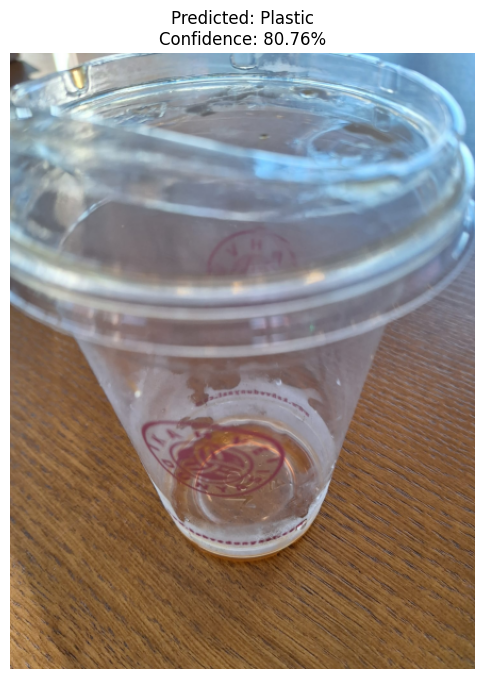

The image is classified as 'Plastic' with 80.76% confidence.


In [17]:
predict_image('\image') #Does not exist in the dataset

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


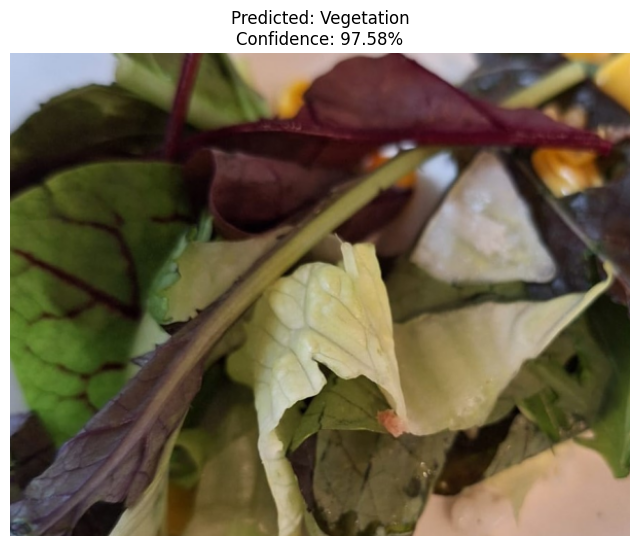

The image is classified as 'Vegetation' with 97.58% confidence.


In [18]:
predict_image('image') #Does not exist in the dataset